## Question 4.1 & 4.2 & 4.3

In [9]:
import torch
import torch.nn as nn

class BaselineModel(nn.Module):
    def __init__(self, embedding_vectors):
        super(BaselineModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_vectors)
        self.fc = nn.Linear(embedding_vectors.size(1), 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=0)
        x = self.fc(x).squeeze(1)
        return x


In [19]:

import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd

# TextDataset is Described in Section 3.3 of Assignment 2

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "../data/"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 
    
# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)


def main(args):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    ### 3.3 Processing of the data ###
    # 3.3.1
    # The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
    glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                   
    # 3.3.2

    train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")
    overfit_dataset = TextDataset(glove, "overfit")
        
    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=args.batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset, 
        batch_size=args.batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))
    
    overfit_dataloader = torch.utils.data.DataLoader(
        dataset=overfit_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        collate_fn=lambda batch: my_collate_function(batch, device))


    # Instantiate your model(s) and train them and so on 
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with

    model = BaselineModel(glove.vectors).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # training loop for 50 epochs
    for epoch in range(50):  
        model.train()
        for batch_x, batch_y in train_dataloader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.float())
            loss.backward()
            optimizer.step()

        # validation
        model.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for batch_x, batch_y in validation_dataloader:
                outputs = model(batch_x)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        print(f"Epoch {epoch+1}, Validation Accuracy: {100 * correct / total:.2f}%")




In [15]:
class Args:
    def __init__(self, batch_size):
        self.batch_size = batch_size

In [16]:
args = Args(batch_size=128)
main(args)

Using device: cpu
Epoch 1, Validation Accuracy: 62.70%
Epoch 2, Validation Accuracy: 74.41%
Epoch 3, Validation Accuracy: 76.85%
Epoch 4, Validation Accuracy: 78.66%
Epoch 5, Validation Accuracy: 79.22%
Epoch 6, Validation Accuracy: 80.41%
Epoch 7, Validation Accuracy: 81.16%
Epoch 8, Validation Accuracy: 81.85%
Epoch 9, Validation Accuracy: 82.35%
Epoch 10, Validation Accuracy: 82.85%
Epoch 11, Validation Accuracy: 82.98%
Epoch 12, Validation Accuracy: 83.29%
Epoch 13, Validation Accuracy: 83.73%
Epoch 14, Validation Accuracy: 83.92%
Epoch 15, Validation Accuracy: 83.85%
Epoch 16, Validation Accuracy: 84.11%
Epoch 17, Validation Accuracy: 84.54%
Epoch 18, Validation Accuracy: 84.61%
Epoch 19, Validation Accuracy: 84.92%
Epoch 20, Validation Accuracy: 85.04%
Epoch 21, Validation Accuracy: 84.98%
Epoch 22, Validation Accuracy: 85.17%
Epoch 23, Validation Accuracy: 85.11%
Epoch 24, Validation Accuracy: 85.36%
Epoch 25, Validation Accuracy: 85.73%
Epoch 26, Validation Accuracy: 85.92%
Epo

In [17]:
args = Args(batch_size=64)
main(args)

Using device: cpu
Epoch 1, Validation Accuracy: 60.14%
Epoch 2, Validation Accuracy: 78.41%
Epoch 3, Validation Accuracy: 81.60%
Epoch 4, Validation Accuracy: 82.92%
Epoch 5, Validation Accuracy: 83.04%
Epoch 6, Validation Accuracy: 83.42%
Epoch 7, Validation Accuracy: 83.60%
Epoch 8, Validation Accuracy: 84.17%
Epoch 9, Validation Accuracy: 84.42%
Epoch 10, Validation Accuracy: 84.79%
Epoch 11, Validation Accuracy: 85.17%
Epoch 12, Validation Accuracy: 85.23%
Epoch 13, Validation Accuracy: 85.54%
Epoch 14, Validation Accuracy: 86.05%
Epoch 15, Validation Accuracy: 86.23%
Epoch 16, Validation Accuracy: 86.11%
Epoch 17, Validation Accuracy: 86.11%
Epoch 18, Validation Accuracy: 86.05%
Epoch 19, Validation Accuracy: 86.30%
Epoch 20, Validation Accuracy: 86.30%
Epoch 21, Validation Accuracy: 86.36%
Epoch 22, Validation Accuracy: 86.36%
Epoch 23, Validation Accuracy: 86.42%
Epoch 24, Validation Accuracy: 86.42%
Epoch 25, Validation Accuracy: 86.42%
Epoch 26, Validation Accuracy: 86.36%
Epo

In [18]:
args = Args(batch_size=32)
main(args)

Using device: cpu
Epoch 1, Validation Accuracy: 59.07%
Epoch 2, Validation Accuracy: 79.41%
Epoch 3, Validation Accuracy: 83.10%
Epoch 4, Validation Accuracy: 83.98%
Epoch 5, Validation Accuracy: 84.61%
Epoch 6, Validation Accuracy: 85.29%
Epoch 7, Validation Accuracy: 85.73%
Epoch 8, Validation Accuracy: 85.98%
Epoch 9, Validation Accuracy: 85.98%
Epoch 10, Validation Accuracy: 86.11%
Epoch 11, Validation Accuracy: 86.23%
Epoch 12, Validation Accuracy: 86.23%
Epoch 13, Validation Accuracy: 86.36%
Epoch 14, Validation Accuracy: 86.55%
Epoch 15, Validation Accuracy: 86.55%
Epoch 16, Validation Accuracy: 86.55%
Epoch 17, Validation Accuracy: 86.86%
Epoch 18, Validation Accuracy: 86.86%
Epoch 19, Validation Accuracy: 87.05%
Epoch 20, Validation Accuracy: 87.17%
Epoch 21, Validation Accuracy: 87.42%
Epoch 22, Validation Accuracy: 87.42%
Epoch 23, Validation Accuracy: 87.36%
Epoch 24, Validation Accuracy: 87.30%
Epoch 25, Validation Accuracy: 87.42%
Epoch 26, Validation Accuracy: 87.61%
Epo

## Question 4.4

In [36]:

import torch
import torchtext
from torchtext import data
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import pandas as pd

# TextDataset is Described in Section 3.3 of Assignment 2

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "../data/"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 
    
# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)


def main(args):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    ### 3.3 Processing of the data ###
    # 3.3.1
    # The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
    glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                   
    # 3.3.2

    train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")
    overfit_dataset = TextDataset(glove, "overfit")
        
    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=args.batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset, 
        batch_size=args.batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))
    
    overfit_dataloader = torch.utils.data.DataLoader(
        dataset=overfit_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        collate_fn=lambda batch: my_collate_function(batch, device))


    # Instantiate your model(s) and train them and so on 
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with

    model = BaselineModel(glove.vectors).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)

    train_losses = []
    train_accuracies = []

    num_epochs = 300
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        for batch_x, batch_y in overfit_dataloader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        train_losses.append(epoch_loss / len(overfit_dataloader))
        train_accuracies.append(100 * correct / total)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(overfit_dataloader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    # plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss for Overfitting')
    plt.legend()
    plt.show()

    # plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy for Overfitting')
    plt.legend()
    plt.show()


Using device: cpu
Epoch 1/300, Loss: 1.0497, Accuracy: 46.00%
Epoch 2/300, Loss: 0.7350, Accuracy: 54.00%
Epoch 3/300, Loss: 0.8955, Accuracy: 50.00%
Epoch 4/300, Loss: 0.6048, Accuracy: 68.00%
Epoch 5/300, Loss: 0.7648, Accuracy: 60.00%
Epoch 6/300, Loss: 0.6759, Accuracy: 58.00%
Epoch 7/300, Loss: 0.5531, Accuracy: 76.00%
Epoch 8/300, Loss: 0.6217, Accuracy: 50.00%
Epoch 9/300, Loss: 0.5446, Accuracy: 76.00%
Epoch 10/300, Loss: 0.5325, Accuracy: 74.00%
Epoch 11/300, Loss: 0.4914, Accuracy: 74.00%
Epoch 12/300, Loss: 0.4598, Accuracy: 82.00%
Epoch 13/300, Loss: 0.4778, Accuracy: 74.00%
Epoch 14/300, Loss: 0.4631, Accuracy: 78.00%
Epoch 15/300, Loss: 0.4371, Accuracy: 84.00%
Epoch 16/300, Loss: 0.4410, Accuracy: 82.00%
Epoch 17/300, Loss: 0.4190, Accuracy: 86.00%
Epoch 18/300, Loss: 0.4079, Accuracy: 86.00%
Epoch 19/300, Loss: 0.3977, Accuracy: 84.00%
Epoch 20/300, Loss: 0.4008, Accuracy: 84.00%
Epoch 21/300, Loss: 0.3741, Accuracy: 84.00%
Epoch 22/300, Loss: 0.3764, Accuracy: 88.00%
E

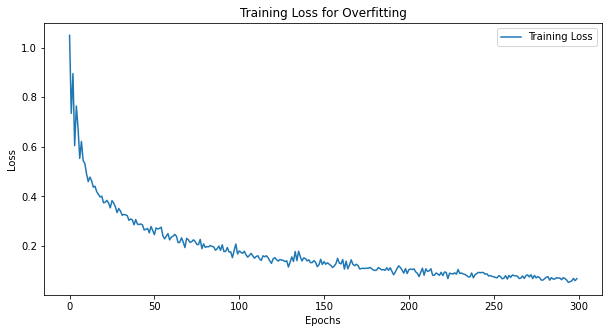

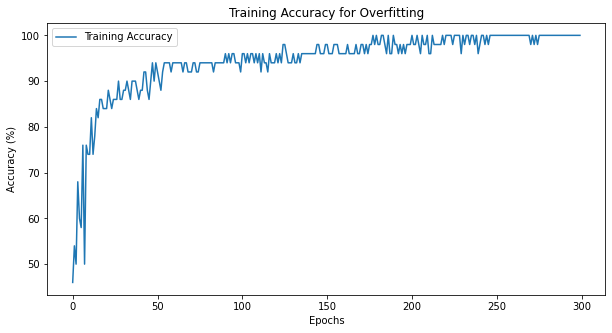

In [37]:
args = Args(batch_size=32)
main(args)

## Question 4.5

In [38]:
#   fix seed
torch.manual_seed(2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)

### 3.3 Processing of the data ###
# 3.3.1
# The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                
# 3.3.2

train_dataset = TextDataset(glove, "train")
val_dataset = TextDataset(glove, "validation")
test_dataset = TextDataset(glove, "test")
overfit_dataset = TextDataset(glove, "overfit")
    
# 3.3.3
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=args.batch_size, 
    shuffle=False, 
    collate_fn=lambda batch: my_collate_function(batch, device))

validation_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, 
    batch_size=args.batch_size, 
    shuffle=False, 
    collate_fn=lambda batch: my_collate_function(batch, device))

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device))

overfit_dataloader = torch.utils.data.DataLoader(
    dataset=overfit_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    collate_fn=lambda batch: my_collate_function(batch, device))

Using device: cpu


In [39]:
# define model, loss function and hyperparameters
model = BaselineModel(glove.vectors).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# using 50 epochs of training
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_x, batch_y in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y.float())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()

    train_losses.append(epoch_train_loss / len(train_dataloader))
    train_accuracies.append(100 * correct_train / total_train)
    
    # Validation
    model.eval()
    epoch_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_x, batch_y in validation_dataloader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.float())
            epoch_val_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += batch_y.size(0)
            correct_val += (predicted == batch_y).sum().item()

    val_losses.append(epoch_val_loss / len(validation_dataloader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss / len(train_dataloader):.4f}, Training Accuracy: {100 * correct_train / total_train:.2f}%, Validation Loss: {epoch_val_loss / len(validation_dataloader):.4f}, Validation Accuracy: {100 * correct_val / total_val:.2f}%")


Epoch 1/50, Training Loss: 0.6842, Training Accuracy: 61.02%, Validation Loss: 0.6690, Validation Accuracy: 59.07%
Epoch 2/50, Training Loss: 0.6549, Training Accuracy: 75.14%, Validation Loss: 0.6412, Validation Accuracy: 79.41%
Epoch 3/50, Training Loss: 0.6291, Training Accuracy: 79.06%, Validation Loss: 0.6166, Validation Accuracy: 83.10%
Epoch 4/50, Training Loss: 0.6063, Training Accuracy: 81.17%, Validation Loss: 0.5948, Validation Accuracy: 83.98%
Epoch 5/50, Training Loss: 0.5860, Training Accuracy: 82.31%, Validation Loss: 0.5753, Validation Accuracy: 84.61%
Epoch 6/50, Training Loss: 0.5677, Training Accuracy: 83.34%, Validation Loss: 0.5577, Validation Accuracy: 85.29%
Epoch 7/50, Training Loss: 0.5512, Training Accuracy: 84.12%, Validation Loss: 0.5418, Validation Accuracy: 85.73%
Epoch 8/50, Training Loss: 0.5362, Training Accuracy: 84.64%, Validation Loss: 0.5274, Validation Accuracy: 85.98%
Epoch 9/50, Training Loss: 0.5227, Training Accuracy: 84.95%, Validation Loss: 0

In [40]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.float())
            epoch_loss += loss.item()
            
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    return epoch_loss / len(dataloader), 100 * correct / total


In [44]:
# define model, loss function and hyperparameters
model = BaselineModel(glove.vectors).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# using 50 epochs of training
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_x, batch_y in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y.float())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()

    train_losses.append(epoch_train_loss / len(train_dataloader))
    train_accuracies.append(100 * correct_train / total_train)
    
    # Validation
    val_loss, val_acc = evaluate(model, validation_dataloader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 1/50, Training Loss: 0.6815, Training Accuracy: 61.02%, Validation Loss: 0.6658, Validation Accuracy: 64.83%
Test Loss: 0.6662, Test Accuracy: 63.64%
Epoch 2/50, Training Loss: 0.6525, Training Accuracy: 74.64%, Validation Loss: 0.6387, Validation Accuracy: 78.79%
Test Loss: 0.6395, Test Accuracy: 78.47%
Epoch 3/50, Training Loss: 0.6272, Training Accuracy: 78.50%, Validation Loss: 0.6146, Validation Accuracy: 82.60%
Test Loss: 0.6157, Test Accuracy: 82.82%
Epoch 4/50, Training Loss: 0.6048, Training Accuracy: 81.03%, Validation Loss: 0.5931, Validation Accuracy: 83.79%
Test Loss: 0.5944, Test Accuracy: 84.42%
Epoch 5/50, Training Loss: 0.5846, Training Accuracy: 82.45%, Validation Loss: 0.5737, Validation Accuracy: 84.61%
Test Loss: 0.5752, Test Accuracy: 85.21%
Epoch 6/50, Training Loss: 0.5665, Training Accuracy: 83.30%, Validation Loss: 0.5563, Validation Accuracy: 85.23%
Test Loss: 0.5578, Test Accuracy: 85.41%
Epoch 7/50, Training Loss: 0.5501, Training Accuracy: 84.08%, Va

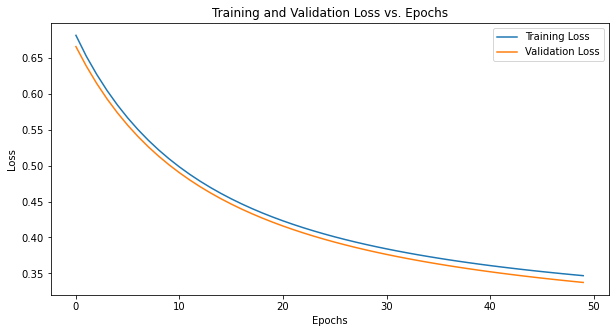

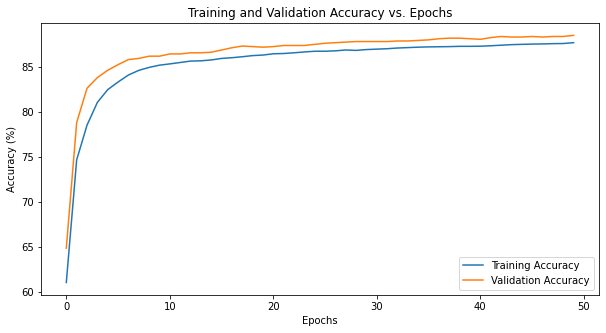

In [45]:
import matplotlib.pyplot as plt

# plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.show()

# plot accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy vs. Epochs')
plt.legend()
plt.show()

## Question 4.6

In [58]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def print_closest_cosine_words(vec, n=5):
    # Compute the cosine similarity between the input vector and all the words
    similarities = cosine_similarity(vec.reshape(1, -1), glove.vectors)
    
    # find the n most similar words
    top_indices = np.argsort(similarities[0])[::-1][:n]

    # print the most similar words and their similarities
    for idx in top_indices:
        similarity = similarities[0][idx]
        print(glove.itos[idx], "\t%5.2f" % similarity)

In [59]:
# extract linear layer weights in the model
linear_weights = model.fc.weight.detach().cpu().numpy()

# find the 20 closest words
print_closest_cosine_words(linear_weights, n=20)

visuals 	 0.56
simplistic 	 0.56
pleasing 	 0.55
watchable 	 0.54
insipid 	 0.54
realistic 	 0.53
flattering 	 0.53
cheesy 	 0.52
engrossing 	 0.52
laughable 	 0.52
cartoonish 	 0.52
disquieting 	 0.52
cartoony 	 0.51
encapsulates 	 0.51
verisimilitude 	 0.51
campy 	 0.51
refreshingly 	 0.50
bracingly 	 0.50
nuanced 	 0.50
silliness 	 0.50


## Question 4.7

In [62]:
# define model, loss function and hyperparameters
model = BaselineModel(glove.vectors).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')

# using 50 epochs of training
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_x, batch_y in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y.float())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()

    train_losses.append(epoch_train_loss / len(train_dataloader))
    train_accuracies.append(100 * correct_train / total_train)
    
    # validation
    val_loss, val_acc = evaluate(model, validation_dataloader, criterion, device)

    # save the model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print("Best val_loss: ", best_val_loss)
        torch.save(model.state_dict(), 'model_baseline.pt')

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

Best val_loss:  0.6682875883579255
Epoch 1/30, Training Loss: 0.6844, Training Accuracy: 60.16%, Validation Loss: 0.6683, Validation Accuracy: 58.14%
Best val_loss:  0.6404923617839813
Epoch 2/30, Training Loss: 0.6551, Training Accuracy: 75.27%, Validation Loss: 0.6405, Validation Accuracy: 80.41%
Best val_loss:  0.6160377502441406
Epoch 3/30, Training Loss: 0.6294, Training Accuracy: 79.34%, Validation Loss: 0.6160, Validation Accuracy: 83.10%
Best val_loss:  0.5942786014080048
Epoch 4/30, Training Loss: 0.6066, Training Accuracy: 81.25%, Validation Loss: 0.5943, Validation Accuracy: 84.29%
Best val_loss:  0.5747787189483643
Epoch 5/30, Training Loss: 0.5862, Training Accuracy: 82.64%, Validation Loss: 0.5748, Validation Accuracy: 84.86%
Best val_loss:  0.5572115337848663
Epoch 6/30, Training Loss: 0.5679, Training Accuracy: 83.41%, Validation Loss: 0.5572, Validation Accuracy: 85.48%
Best val_loss:  0.5413160514831543
Epoch 7/30, Training Loss: 0.5513, Training Accuracy: 84.19%, Val

## Question 4.8

### For the using, can run each cell by order.